In [ ]:
#Synthyra把ESM2系列的模型都做成了hugging face能较好使用的样子，还挺厉害的，等于说有蛋白大模型可以使用了
#不过我目前对于这种模型的理解就还是在分类回归和水平，还是需要学习

In [41]:
import torch
from transformers import AutoModel, AutoTokenizer

In [4]:
#pip install einops

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 4.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [10]:
model_path  = "/scratch/lb4489/LLM"


model = AutoModel.from_pretrained("Synthyra/ESM2-650M", cache_dir=model_path, torch_dtype=torch.float16, trust_remote_code=True).eval()
tokenizer = model.tokenizer

sequences = ['MPRTEIN', 'MSEQWENCE']
tokenized = tokenizer(sequences, padding=True, return_tensors='pt')
with torch.no_grad():
    embeddings = model(**tokenized).last_hidden_state

print(embeddings.shape) 

A new version of the following files was downloaded from https://huggingface.co/Synthyra/ESM2-650M:
- modeling_fastesm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
Some weights of FastEsmModel were not initialized from the model checkpoint at Synthyra/ESM2-650M and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([2, 11, 1280])


In [7]:
from transformers import AutoModelForMaskedLM, AutoTokenizer

model = AutoModelForMaskedLM.from_pretrained("Synthyra/ESM2-8M", cache_dir=model_path, torch_dtype=torch.float16, trust_remote_code=True).eval()

with torch.no_grad():
    logits = model(**tokenized).logits

print(logits.shape) # (2, 11, 33)


torch.Size([2, 11, 33])


In [10]:

model = AutoModel.from_pretrained("Synthyra/ESM2-8M", cache_dir=model_path, torch_dtype=torch.float16, trust_remote_code=True).eval()
with torch.no_grad():
    attentions = model(**tokenized, output_attentions=True).attentions # tuples of (batch_size, num_heads, seq_len, seq_len)

print(attentions[-1].shape)

Some weights of FastEsmModel were not initialized from the model checkpoint at Synthyra/ESM2-8M and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([2, 20, 11, 11])


In [11]:
with torch.no_grad():
    contact_map = model.predict_contacts(**tokenized).squeeze().cpu().numpy() # (seq_len, seq_len)


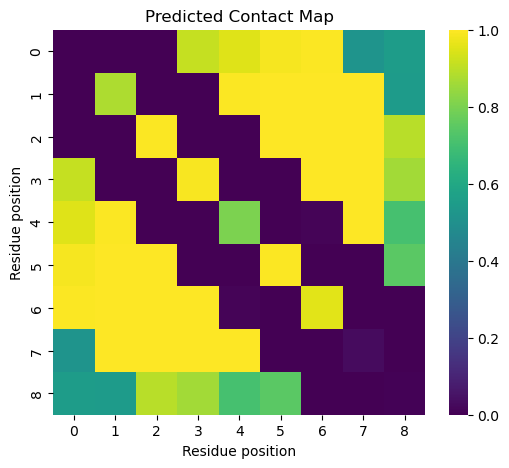

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

contact_maps = contact_map[1]

plt.figure(figsize=(6, 5))
sns.heatmap(contact_maps, cmap='viridis')
plt.title("Predicted Contact Map")
plt.xlabel("Residue position")
plt.ylabel("Residue position")
plt.show()

In [45]:
from Bio.PDB import PDBParser, is_aa
import numpy as np

def extract_ca_coords_and_sequence(pdb_file, chain_id='A'):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    model = structure[0]
    chain = model[chain_id]

    coords = []
    sequence = []

    for residue in chain:
        if is_aa(residue):
            if 'CA' in residue:
                ca = residue['CA'].get_coord()
                coords.append(ca)
                sequence.append(residue.get_resname())

    coords = np.array(coords)  # shape: (L, 3)
    return sequence, coords


In [46]:
from scipy.spatial.distance import cdist

def compute_distance_matrix(ca_coords):
    return cdist(ca_coords, ca_coords)  # shape: (L, L)


In [47]:
def compute_contact_map(dist_matrix, threshold=8.0):
    contact_map = (dist_matrix < threshold).astype(float)
    np.fill_diagonal(contact_map, 0)  # 去掉对角线（自己不和自己接触）
    return contact_map


In [48]:
#真实位置

pdb_file = "/scratch/lb4489/project/colabfold/2jo1.pdb"
chain_id = "A"

seq, coords = extract_ca_coords_and_sequence(pdb_file, chain_id)
dist_mat = compute_distance_matrix(coords)
true_map = compute_contact_map(dist_mat, threshold=8.0)


In [49]:
from Bio.Data.IUPACData import protein_letters_3to1

def convert_seq_3to1(triplets):
    seq1 = []
    for res in triplets:
        try:
            seq1.append(protein_letters_3to1[res.capitalize()])
        except KeyError:
            seq1.append('X')  # 如果是未知残基
    return ''.join(seq1)

seq_string = convert_seq_3to1(seq)  # 输出 "MTMFKG..."
print(seq_string)

ESPKEHDPFTYDYQSLQIGGLVIAGILFILGILIVLSRRCRCKFNQQQRTGEPDEEEGTFRSSIRRLSTRRR


In [42]:
model = AutoModel.from_pretrained("Synthyra/ESM2-650M", cache_dir=model_path, torch_dtype=torch.float16, trust_remote_code=True).eval()

device = torch.device("cuda")
model = model.to(device)

Some weights of FastEsmModel were not initialized from the model checkpoint at Synthyra/ESM2-650M and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
device = torch.device("cuda")

In [38]:
sequences = ['ESPKEHDPFTYDYQSLQIGGLVIAGILFILGILIVLSRRCRCKFNQQQRTGEPDEEEGTFRSSIRRLSTRRR']
tokenized = tokenizer(sequences, padding=True, return_tensors='pt')
tokenized = {k: v.to(device) for k, v in tokenized.items()} #使用gpu预测的话需要移到cuda

In [43]:
with torch.no_grad():
    contact_map = model.predict_contacts(**tokenized).squeeze().cpu().numpy()

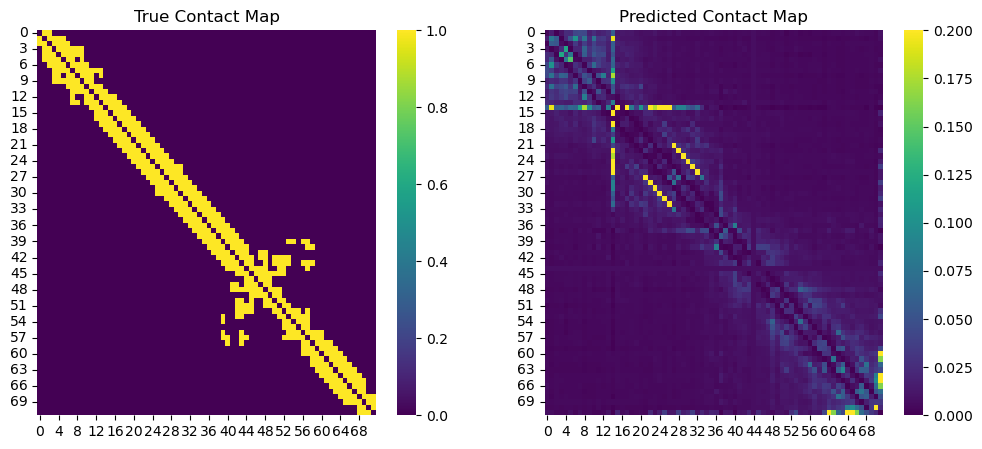

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("True Contact Map")
sns.heatmap(true_map, cmap='viridis', vmin=0, vmax=1)
plt.subplot(1, 2, 2)
plt.title("Predicted Contact Map")
sns.heatmap(contact_map, cmap='viridis', vmin=0, vmax=0.2)
plt.show()

In [5]:
from transformers import AutoTokenizer, EsmForProteinFolding

/home/lb4489/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
model_path  = "/scratch/lb4489/LLM"

tokenizer = AutoTokenizer.from_pretrained("facebook/esmfold_v1", cache_dir=model_path)
model = EsmForProteinFolding.from_pretrained("facebook/esmfold_v1", cache_dir=model_path , low_cpu_mem_usage=True)

model = model.cuda()

Some weights of EsmForProteinFolding were not initialized from the model checkpoint at facebook/esmfold_v1 and are newly initialized: ['esm.contact_head.regression.bias', 'esm.contact_head.regression.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
model.esm = model.esm.half()

In [8]:
test_protein = "MALHDMEDFTFDGTKRLSVNYVKGILQPTDTCDIWDKIWNFQAKPDDLLISTYPKAGTTWTQEIVELIQNEGDVEKSKRAPTHQRFPFLEMKIPSLGSGLEQAHAMPSPRILKTHLPFHLLPPSLLEKNCKIIYVARNPKDNMVSYYHFQRMNKALPAPGTWEEYFETFLAGKVCWGSWHEHVKGWWEAKDKHRILYLFYEDMKKNPKHEIQKLAEFIGKKLDDKVLDKIVHYTSFDVMKQNPMANYSSIPAEIMDHSISPFMRKGAVGDWKKHFTVAQNERFDEDYKKKMTDTRLTFHFQF"

tokenized_input = tokenizer([test_protein], return_tensors="pt", add_special_tokens=False)['input_ids']

In [9]:
tokenized_input = tokenized_input.cuda()

In [10]:
import torch

with torch.no_grad():
    output = model(tokenized_input)

In [11]:
from transformers.models.esm.openfold_utils.protein import to_pdb, Protein as OFProtein
from transformers.models.esm.openfold_utils.feats import atom14_to_atom37

def convert_outputs_to_pdb(outputs):
    final_atom_positions = atom14_to_atom37(outputs["positions"][-1], outputs)
    outputs = {k: v.to("cpu").numpy() for k, v in outputs.items()}
    final_atom_positions = final_atom_positions.cpu().numpy()
    final_atom_mask = outputs["atom37_atom_exists"]
    pdbs = []
    for i in range(outputs["aatype"].shape[0]):
        aa = outputs["aatype"][i]
        pred_pos = final_atom_positions[i]
        mask = final_atom_mask[i]
        resid = outputs["residue_index"][i] + 1
        pred = OFProtein(
            aatype=aa,
            atom_positions=pred_pos,
            atom_mask=mask,
            residue_index=resid,
            b_factors=outputs["plddt"][i],
            chain_index=outputs["chain_index"][i] if "chain_index" in outputs else None,
        )
        pdbs.append(to_pdb(pred))
    return pdbs

In [12]:
pdb = convert_outputs_to_pdb(output)

In [13]:
import py3Dmol

view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js', width=800, height=400)
view.addModel("".join(pdb), 'pdb')
view.setStyle({'model': -1}, {"cartoon": {'color': 'spectrum'}})

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [14]:
from IPython.display import display, HTML

js_url = 'https://3dmol.org/build/3Dmol.js'

view_pred = py3Dmol.view(js=js_url, width=400, height=400)
view_pred.addModel("".join(pdb), 'pdb')
view_pred.setStyle({'model': -1}, {"cartoon": {'color': 'spectrum'}})
view_pred.zoomTo()

with open("/scratch/lb4489/project/colabfold/ST1C4.ent") as f:
    pdb_real = f.read()

view_real = py3Dmol.view(js=js_url, width=400, height=400)
view_real.addModel(pdb_real, 'pdb')
view_real.setStyle({'model': -1}, {"cartoon": {'color': 'spectrum'}})
view_real.zoomTo()

from IPython.display import display, HTML

display(HTML(f"""
<table>
<tr>
<td><b>Predicted Structure</b><br>{view_pred._make_html()}</td>
<td><b>Real Structure</b><br>{view_real._make_html()}</td>
</tr>
</table>
"""))


In [15]:
pdb_str = "".join(pdb)  # 将列表转成字符串

with open("predicted_structure.pdb", "w") as f:
    f.write(pdb_str)

In [16]:
from Bio.PDB import PDBParser, Superimposer

parser = PDBParser(QUIET=True)

real_structure = parser.get_structure("real", "/scratch/lb4489/project/colabfold/ST1C4.ent")
pred_structure = parser.get_structure("pred", "predicted_structure.pdb")

real_atoms = []
pred_atoms = []

for real_res, pred_res in zip(real_structure[0].get_residues(), pred_structure[0].get_residues()):
    if real_res.has_id("CA") and pred_res.has_id("CA"):
        real_atoms.append(real_res["CA"])
        pred_atoms.append(pred_res["CA"])

sup = Superimposer()
sup.set_atoms(real_atoms, pred_atoms)
sup.apply(pred_structure.get_atoms()) 

print(f"RMSD: {sup.rms:.3f} Å")


RMSD: 20.711 Å


In [20]:
#氨基酸对齐的版本
from Bio.PDB import PDBParser, Superimposer

parser = PDBParser(QUIET=True)

real_structure = parser.get_structure("real", "/scratch/lb4489/project/colabfold/ST1C4.ent")
pred_structure = parser.get_structure("pred", "predicted_structure.pdb")

real_ca_dict = {
    res.get_id()[1]: res["CA"]
    for res in real_structure[0].get_residues()
    if res.has_id("CA")
}

pred_ca_dict = {
    res.get_id()[1]: res["CA"]
    for res in pred_structure[0].get_residues()
    if res.has_id("CA")
}

common_ids = sorted(set(real_ca_dict.keys()) & set(pred_ca_dict.keys()))

real_atoms = [real_ca_dict[i] for i in common_ids]
pred_atoms = [pred_ca_dict[i] for i in common_ids]

sup = Superimposer()
sup.set_atoms(real_atoms, pred_atoms)
sup.apply(pred_structure.get_atoms())

print(f"RMSD (on {len(common_ids)} matched residues): {sup.rms:.3f} Å")


RMSD (on 244 matched residues): 11.151 Å


In [17]:
from Bio.PDB import PDBParser, Superimposer

parser = PDBParser(QUIET=True)

real_structure = parser.get_structure("real", "/scratch/lb4489/project/colabfold/ST1C4.ent")
pred_structure = parser.get_structure("pred", "/scratch/lb4489/project/colabfold/ST1C4_AF.pdb")

real_atoms = []
pred_atoms = []

for real_res, pred_res in zip(real_structure[0].get_residues(), pred_structure[0].get_residues()):
    if real_res.has_id("CA") and pred_res.has_id("CA"):
        real_atoms.append(real_res["CA"])
        pred_atoms.append(pred_res["CA"])

sup = Superimposer()
sup.set_atoms(real_atoms, pred_atoms)
sup.apply(pred_structure.get_atoms()) 

print(f"RMSD: {sup.rms:.3f} Å")

RMSD: 19.809 Å


In [21]:
#氨基酸对齐的版本
from Bio.PDB import PDBParser, Superimposer

parser = PDBParser(QUIET=True)

real_structure = parser.get_structure("real", "/scratch/lb4489/project/colabfold/ST1C4.ent")
pred_structure = parser.get_structure("pred", "/scratch/lb4489/project/colabfold/ST1C4_AF.pdb")

real_ca_dict = {
    res.get_id()[1]: res["CA"]
    for res in real_structure[0].get_residues()
    if res.has_id("CA")
}

pred_ca_dict = {
    res.get_id()[1]: res["CA"]
    for res in pred_structure[0].get_residues()
    if res.has_id("CA")
}

common_ids = sorted(set(real_ca_dict.keys()) & set(pred_ca_dict.keys()))

real_atoms = [real_ca_dict[i] for i in common_ids]
pred_atoms = [pred_ca_dict[i] for i in common_ids]

sup = Superimposer()
sup.set_atoms(real_atoms, pred_atoms)
sup.apply(pred_structure.get_atoms())

print(f"RMSD (on {len(common_ids)} matched residues): {sup.rms:.3f} Å")


RMSD (on 244 matched residues): 11.288 Å


In [26]:
from Bio.PDB import PDBParser, Select, PDBIO

parser = PDBParser(QUIET=True)
real = parser.get_structure("real", "/scratch/lb4489/project/colabfold/ST1C4.ent")
pred = parser.get_structure("pred", "predicted_structure.pdb")

def get_ca_residues(structure):
    ca_dict = {}
    for res in structure[0].get_residues():
        if res.has_id("CA"):
            resid = res.get_id()[1]
            ca_dict[resid] = res
    return ca_dict

real_ca = get_ca_residues(real)
pred_ca = get_ca_residues(pred)

common_res_ids = sorted(set(real_ca.keys()) & set(pred_ca.keys()))

class ResidueSelector(Select):
    def __init__(self, keep_ids):
        self.keep_ids = keep_ids
    def accept_residue(self, residue):
        return residue.get_id()[1] in self.keep_ids

io = PDBIO()

io.set_structure(pred)
io.save("predicted_trimmed_matched.pdb", ResidueSelector(common_res_ids))

io.set_structure(real)
io.save("real_trimmed_matched.pdb", ResidueSelector(common_res_ids))



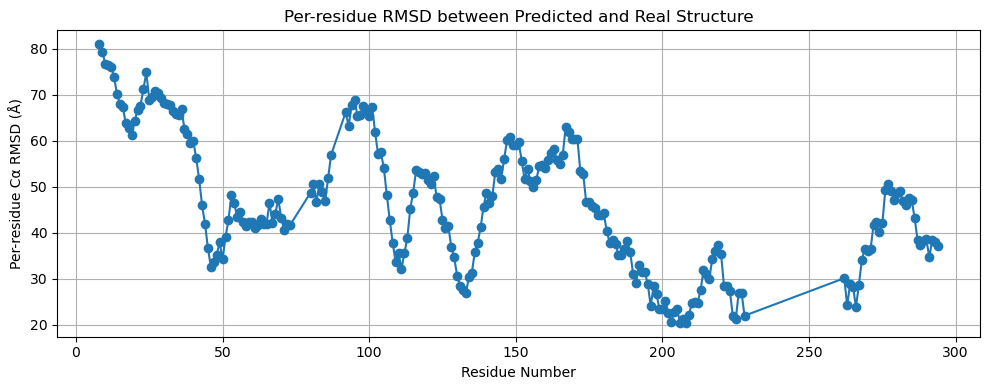

In [27]:
from Bio.PDB import PDBParser
import numpy as np
import matplotlib.pyplot as plt

parser = PDBParser(QUIET=True)
real = parser.get_structure("real", "real_trimmed_matched.pdb")
pred = parser.get_structure("pred", "predicted_trimmed_matched.pdb")

real_atoms = []
pred_atoms = []
residue_ids = []

for real_res, pred_res in zip(real[0].get_residues(), pred[0].get_residues()):
    if real_res.has_id("CA") and pred_res.has_id("CA"):
        real_ca = real_res["CA"]
        pred_ca = pred_res["CA"]
        real_atoms.append(real_ca)
        pred_atoms.append(pred_ca)
        residue_ids.append(real_res.get_id()[1]) 

rmsd_per_residue = [
    np.linalg.norm(real_ca.coord - pred_ca.coord)
    for real_ca, pred_ca in zip(real_atoms, pred_atoms)
]

plt.figure(figsize=(10, 4))
plt.plot(residue_ids, rmsd_per_residue, marker='o', linestyle='-')
plt.xlabel("Residue Number")
plt.ylabel("Per-residue Cα RMSD (Å)")
plt.title("Per-residue RMSD between Predicted and Real Structure")
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
from tmscoring import TMscoring, RMSDscoring, Sscoring

alignment = TMscoring('real_trimmed_matched.pdb', 'predicted_trimmed_matched.pdb')

# Find the optimal alignment
alignment.optimise()

# Get the TM score:
alignment.tmscore(**alignment.get_current_values())

# Get the TM local scores:
alignment.tmscore_samples(**alignment.get_current_values())

# RMSD of the protein aligned according to TM score
alignment.rmsd(**alignment.get_current_values())

# Returns the transformation matrix between both structures:
alignment.get_matrix(**alignment.get_current_values())

/tmpdata/ipykernel_2493368/2223194511.py:6: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  alignment.optimise()


array([[-2.77184997e-02, -4.17173156e-01, -9.08404229e-01,
        -3.74962436e-01],
       [ 8.93159674e-01,  3.97746387e-01, -2.09913336e-01,
         3.37118718e+01],
       [ 4.48884708e-01, -8.17168507e-01,  3.61577307e-01,
         2.30878213e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [29]:
score = alignment.tmscore(**alignment.get_current_values())
print("Global TM-score:", score)

Global TM-score: 0.32990159814986486


In [30]:
from Bio.PDB import PDBParser, Select, PDBIO

parser = PDBParser(QUIET=True)
real = parser.get_structure("real", "/scratch/lb4489/project/colabfold/ST1C4.ent")
pred = parser.get_structure("pred", "/scratch/lb4489/project/colabfold/ST1C4_AF.pdb")

def get_ca_residues(structure):
    ca_dict = {}
    for res in structure[0].get_residues():
        if res.has_id("CA"):
            resid = res.get_id()[1]
            ca_dict[resid] = res
    return ca_dict

real_ca = get_ca_residues(real)
pred_ca = get_ca_residues(pred)

common_res_ids = sorted(set(real_ca.keys()) & set(pred_ca.keys()))

class ResidueSelector(Select):
    def __init__(self, keep_ids):
        self.keep_ids = keep_ids
    def accept_residue(self, residue):
        return residue.get_id()[1] in self.keep_ids

io = PDBIO()

io.set_structure(pred)
io.save("predicted_trimmed_matched_AF.pdb", ResidueSelector(common_res_ids))

io.set_structure(real)
io.save("real_trimmed_matched_AF.pdb", ResidueSelector(common_res_ids))

In [31]:
from tmscoring import TMscoring, RMSDscoring, Sscoring

alignment = TMscoring('real_trimmed_matched_AF.pdb', 'predicted_trimmed_matched_AF.pdb')

alignment.optimise()

alignment.tmscore(**alignment.get_current_values())

alignment.tmscore_samples(**alignment.get_current_values())

alignment.rmsd(**alignment.get_current_values())

alignment.get_matrix(**alignment.get_current_values())

score = alignment.tmscore(**alignment.get_current_values())
print("Global TM-score:", score)

Global TM-score: 0.32174632870965164


/tmpdata/ipykernel_2493368/2589315567.py:6: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  alignment.optimise()


In [ ]:
#这个结构无论是alphafold还是esm fold都不太行？还是对齐有问题?

In [32]:
from tmscoring import TMscoring, RMSDscoring, Sscoring

alignment = TMscoring('predicted_structure.pdb', '/scratch/lb4489/project/colabfold/ST1C4_AF.pdb')

alignment.optimise()

score = alignment.tmscore(**alignment.get_current_values())

print("Global TM-score:", score)

Global TM-score: 0.9501693062614865


/tmpdata/ipykernel_2493368/3643422900.py:5: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  alignment.optimise()


In [ ]:
#两个预测结构极其相似，厉害啊

In [33]:
protein1 = "PIVQNLQGQMVHQAISPRTLNAWVKVVEEKAFSPEVIPMFSALSEGATPQDLNTMLNTVGGHQAAMQMLKETINEEAAEWDRLHPVHAGPIAPGQMREPRGSDIAGTTSTLQEQIGWMTHNPPIPVGEIYKRWIILGLNKIVRMY"
protein2 ="MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGFGYKGSCFHRIIPGFMCQGGDFTRHNGTGGKSIYGEKFEDENFILKHTGPGILSMANAGPNTNGSQFFICTAKTEWLDGKHVVFGKVKEGMNIVEAMERFGSRNGKTSKKITIADCGQLE"
poly_g_linker = "G" * 25  
combined_sequence = protein1 + poly_g_linker + protein2


In [34]:
tokenized_input = tokenizer([combined_sequence], return_tensors="pt", add_special_tokens=False)['input_ids']

tokenized_input = tokenized_input.cuda()

In [35]:
with torch.no_grad():
    output = model(tokenized_input)

pdb = convert_outputs_to_pdb(output)

In [93]:
def split_pdb_by_linker(pdb_lines, linker_start, linker_end):
    output = []
    current_chain = 'A'
    new_res_id = 1
    seen_resid = None
    in_chain_b = False

    for i, line in enumerate(pdb_lines):
        if not line.startswith("ATOM"):
            output.append(line)
            continue

        resid = int(line[22:26])

        if linker_start <= resid <= linker_end:
            continue

        if resid > linker_end and not in_chain_b:
            last_atom_num = int(output[-1][6:11])
            last_resname = output[-1][17:20]
            last_chain = output[-1][21]
            last_resid = output[-1][22:26]
            ter_line = f"TER   {last_atom_num + 1:5d}      {last_resname} {last_chain}{last_resid}\n"
            output.append(ter_line)
            current_chain = 'B'
            new_res_id = 1
            seen_resid = None
            in_chain_b = True

        old_resid = int(line[22:26])
        if old_resid != seen_resid:
            seen_resid = old_resid
            new_res_id += 1

        new_line = (
            line[:21] + current_chain + f"{new_res_id:4d}" + line[26:]
        )
        output.append(new_line)

    output.append("END\n")
    return output


In [101]:
linker_start = len(protein1) + 1
linker_end = linker_start + 25 - 1

pdb_lines = pdb[0].splitlines(keepends=True)

pdb_clean_split = split_pdb_by_residue_range(pdb_lines, linker_start, linker_end)

import py3Dmol

view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js', width=800, height=400)
view.addModel("".join(pdb_clean_split), 'pdb')

view.setStyle({'chain': 'A'}, {"cartoon": {"color": "pink"}})
view.setStyle({'chain': 'B'}, {"cartoon": {"color": "yellow"}})

view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [99]:
with open("split_AB.pdb", "w") as f:
    f.writelines(pdb_clean_split)

In [102]:
from Bio.PDB import PDBParser, ShrakeRupley

parser = PDBParser(QUIET=True)
structure = parser.get_structure("complex", "split_AB.pdb")

sr = ShrakeRupley(probe_radius=1.4, n_points=100)

sr.compute(structure, level='A') 

model = structure[0]
chain_a = model['A']
chain_b = model['B']

def get_chain_sasa(chain):
    return sum(atom.sasa for residue in chain for atom in residue)

sasa_a = get_chain_sasa(chain_a)
sasa_b = get_chain_sasa(chain_b)
sasa_complex = get_chain_sasa(chain_a) + get_chain_sasa(chain_b)

sr.compute(structure)
sasa_total = sum(atom.sasa for atom in structure.get_atoms())

bsa = sasa_a + sasa_b - sasa_total

print(f"SASA(chain A): {sasa_a:.2f} Å²")
print(f"SASA(chain B): {sasa_b:.2f} Å²")
print(f"SASA(complex): {sasa_total:.2f} Å²")
print(f"✅ Buried Surface Area (BSA): {bsa:.2f} Å²")


SASA(chain A): 9869.36 Å²
SASA(chain B): 7581.50 Å²
SASA(complex): 17450.86 Å²
✅ Buried Surface Area (BSA): 0.00 Å²
